<a href="https://colab.research.google.com/github/jefffang19/image_processing_final/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework requirement:
pytorch == 1.6.0

In [7]:
!python --version

Python 3.6.9


In [8]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [9]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [10]:
# if use google colab, mount your drive

from google.colab import drive
drive.mount('/content/gdrive')

dataset_path = F"/content/gdrive/My Drive/ip_final/data/train"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# The structure of the dataset

```
0 (patient)
  |
  | -|- CT => mask
     |- FT => mask
     |- MN => mask
     |- T1 => input image 1
     |- T2 => input image 2
```



In [11]:
import cv2
import matplotlib.pyplot as plt
import os

# Define dataset

In [12]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import os
import numpy as np

In [28]:
class Dataset(BaseDataset):
    """
    Args:
        path (str): path to dataset
        task (str): which task to do
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self,
            path,
            task='CT', # CT, FT, MN
            augmentation=None, 
            preprocessing=None,
    ):
        self.patientId = sorted(os.listdir(path))
        self.num_imgs_of_each_pat = [] # count number of images for each patient
        self.ct = []
        self.ft = []
        self.mn = []
        self.t1 = []
        self.t2 = []

        # append file path
        for i in self.patientId:
          # append each class of images
          _cts = sorted(os.listdir('{}/{}/CT/'.format(path, i)))
          _cts = ['{}/{}/CT/{}'.format(path, i, j) for j in _cts]
          self.ct.append(_cts)
          _fts = sorted(os.listdir('{}/{}/FT/'.format(path, i)))
          _fts = ['{}/{}/FT/{}'.format(path, i, j) for j in _fts]
          self.ft.append(_fts)
          _mns = sorted(os.listdir('{}/{}/MN/'.format(path, i)))
          _mns = ['{}/{}/MN/{}'.format(path, i, j) for j in _mns]
          self.mn.append(_mns)
          _t1s = sorted(os.listdir('{}/{}/T1/'.format(path, i)))
          _t1s = ['{}/{}/T1/{}'.format(path, i, j) for j in _t1s]
          self.t1.append(_t1s)
          _t2s = sorted(os.listdir('{}/{}/T2/'.format(path, i)))
          _t2s = ['{}/{}/T2/{}'.format(path, i, j) for j in _t2s]
          self.t2.append(_t2s)

          # count number of images in each patient
          self.num_imgs_of_each_pat.append(len(_cts))

        # print(self.ct)
        # print(self.ft)
        # print(self.mn)
        # print(self.t1)
        # print(self.t2)


        # check if do augmentation and preprocess
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):

        # count number i in which patient
        i_img = i
        pat = 0
        for n, max_value in enumerate(self.num_imgs_of_each_pat):
          if i_img < max_value:
            break
          else:
            i_img -= max_value
            pat += 1
          
          # if i still bigger than the last images number, raise error
          if n == len(self.num_imgs_of_each_pat) - 1:
            raise 'Dataset index out of range !'

        # now we know we want to get
        # patient id: pat
        # image #: i_img
        
        # read img
        image_t1 = cv2.imread(self.t1[pat][i_img], cv2.IMREAD_GRAYSCALE)
        # image = cv2.resize(image, (800, 640)) # image size of multiple of 2^network_depth ie. 32px
        image_t2 = cv2.imread(self.t2[pat][i_img], cv2.IMREAD_GRAYSCALE)
        mask_ct = cv2.imread(self.ct[pat][i_img], cv2.IMREAD_GRAYSCALE)
        mask_ft = cv2.imread(self.ft[pat][i_img], cv2.IMREAD_GRAYSCALE)
        mask_mn = cv2.imread(self.mn[pat][i_img], cv2.IMREAD_GRAYSCALE)
        # mask = cv2.resize(mask, (800, 640)) # iamge size of multiple of 2^network_depth ie. 32px

        # stack the images and masks
        image = np.stack((image_t1, image_t2), axis=2)
        mask = np.stack((mask_ct, mask_ft, mask_mn), axis=2)
        
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # normalize needs to be done or training evalutation will be wrong
        # normalize needs to do after augmentations, or will cause error
        image = image/255 # normalize image
        mask = mask/255 # normalize image
            
        return image, mask
        
    def __len__(self):
        return np.sum(self.num_imgs_of_each_pat)

In [29]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [30]:
train_set = Dataset(dataset_path)

In [31]:
# number of sets of imgs and labels (t1, t2, ct, ft, mn)
len(train_set)

189

In [32]:
image, mask = train_set[40]

print(image.shape, mask.shape)

(512, 512, 2) (512, 512, 3)


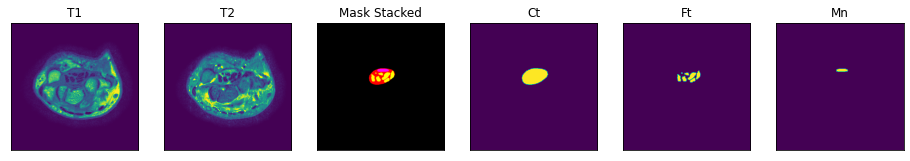

In [39]:
# visual data
visualize(
    t1=image[...,0],
    t2=image[...,1],
    mask_stacked=mask,
    ct=mask[...,0],
    ft=mask[...,1],
    mn=mask[...,2]
)

# preprocess & data augmentation

In [19]:
!pip install -U albumentations

Requirement already up-to-date: albumentations in /usr/local/lib/python3.6/dist-packages (0.5.2)


In [20]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [

      albu.HorizontalFlip(p=0.5),

      albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

      albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
      albu.RandomCrop(height=320, width=320, always_apply=True),

      albu.IAAAdditiveGaussianNoise(p=0.2),
      albu.IAAPerspective(p=0.5),

      albu.OneOf(
          [
              albu.CLAHE(p=1),
              albu.RandomBrightness(p=1),
              albu.RandomGamma(p=1),
          ],
          p=0.9,
      ),

      albu.OneOf(
          [
              albu.IAASharpen(p=1),
              albu.Blur(blur_limit=3, p=1),
              albu.MotionBlur(blur_limit=3, p=1),
          ],
          p=0.9,
      ),

      albu.OneOf(
          [
              albu.RandomContrast(p=1),
              albu.HueSaturationValue(p=1),
          ],
          p=0.9,
      ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def get_preprocessing_no_pretrain():
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


In [22]:
#### Visualize resulted augmented images and masks

augmented_trainset = Dataset(
    dataset_path,
    augmentation=get_training_augmentation(),
)

# same image with different random transforms
for i in range(3):
    t1, t2, ct, ft, mn = augmented_trainset[60]
    visualize(t1=t1, t2=t2, ct=ct, ft=ft, mn=mn)

2 19


UnboundLocalError: ignored